# Start simple, Start linearly

The program below will mark the first RL algorithm truly implemented in this project. As such, to see if I've got the basics down, I started with a simply linear policy to learn. The algorithm contains two main parts. 

* The first is to learn a surrogate dynamics model of the environment. I personally like to think of this as the agent's belief of how the environment behaves, so the term surrogate doesn't too appropriate. A GP model will be used, with a gaussian covariance kernel. 

* The second is to use this belief of the system to learn an optimal policy. As mentioned previously, a linear policy structure will be used. Furthermore, bayesian optimisation with expected improvement will be used to find the optimal policy values. 

In order for the linear policy to be appropriate, the problem definition is changed to keeping a pendulum that starts inverted, with $\pm 5^0$ from equilibrium. As such, the longer the policy can keep the pendulum within those limits, the better it is. To adhere to this limit, all simulations using the actual system are stopped if the position passes those boundaries. 

Let's see how this goes. Fingers crossed. 

In [1]:
%matplotlib inline

import gym
import GPy
import GPyOpt
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import gympy

Once the libraries have been imported as above, the openai gym environment and the appropriate covariance kernels will need to be defined. The former of these can be carried out using the *setupEnvironment* function in the gympy library. This outputs the relevant input and observations arrays, as well as the rewards, action and prediction initial arrays. 

In [3]:
env, observations, inputsNumpy, observationsNumpy, rewardsNumpy, action, predictionPDF = gympy.setupEnvironment(defaultEnvironment = 'Pendulum-v0', whichVersion = 0)
k_dynamics = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.)
k_rewards = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=1.)

Please enter the environment: 


[2016-11-24 17:14:35,798] Making new env: Pendulum-v0


It is now necessary to define the key features of the RL algorithm. These include the how the reward (or cost) will be caluculated, the structure of the policy, and finally the objective function that will be minimised. 

The first of these is how the policy will be calculated. The policy must now be defined in terms of its parameters. In this particular example, a linear policy was chosen, for simplicity. This will be of the form:

$$ \pi(s_t) = \phi(s_t)^T \mathbf{\theta} + \mathbf{b},$$

where the basis functions in $\phi$ are simply the state variables, and the vector $\theta$ represents the weights. Thus the action will be selected by policy that looks like:

$$ a_t = s_{t,1}\theta_1 + s_{t,2}\theta_2  +  s_{t,3}\theta_3 + \theta_4, $$

since this particular problem has 3 state variables. Note that $\theta_4$ is the sum of the vector $\mathbf{b}$. The reinforcement learning problem now becomes one of finiding the values of $\theta$ such that the cost defined earlier is minimised. 

A function is defined to return the action after following the equation above.

In [4]:
def action_fromPolicy(policyParameters, bufferObservations_policy):
    actionToTake_policy = 0
    [r,c] = policyParameters.shape
    for i in range(c):
        if i < c-1:
            actionToTake_policy = actionToTake_policy + (bufferObservations_policy[0,i] * policyParameters[0,i])
        else:
            actionToTake_policy = actionToTake_policy + policyParameters[0,i]
    actionToTake_policy = 2 * ((9/8)*np.sin(actionToTake_policy) + (1/8)*np.sin(3*actionToTake_policy))         

    return actionToTake_policy

Finding the policy parameters that minimise the total reward is clearly an optimisation problem. As such the optimisation method that will be used for this particular notebook is Bayesian Optimisation using Expected Improvement. Simply put, this methods chooses the next test point based on the highest expected improvement from the current minimun point (for a minimising problem that is). Thusly, a good mix of exploration and exploitation can be utilised to find the global minimum given the state box.

The python library GPyOpt will be utilised for this. This requires the definition of an objective function; this is function that is to be optimised. In the present work, this will be the mapping from the policyy parameters to the total reward. Since this is a model based RL algorithm, the GP model that was trained previously will be used to generate the total reward. 

A key feature of this objective function is that it initially uses the actual system, while training the GP model as it gathers training data. It is programmed to switch to the GP model once the percentage error of the predictions from the model have reduced below a certain threshold. In order to save time, the GP model is trained ever time 500 new training points have been gathered. This also acts as a soft check to ensure that the threshold has been satisfied for a few data points. 

The reward, as mentioned in the [previous notebook](Learning_3.ipynb), the reward is function of the current state and the goal state. For the present notebook, the reward is calculated as the sum of the geometric distances between the each of the current states and the goal states. Please note that since each of these will be $ \geqslant \: 0$, it is technically speaking a cost, rather than a reward. However, since the difference betweeen the two is merely a negative symbol, reward and cost will be used interchangebly.

In this case, the reward, or total cost is defined as the inverse of the number of iterations the system stay within the limits defined at the start; the longer it stays, the lower the cost. 

In [5]:
def objectiveFunction(policyParameters):
#     thetaBound = np.array([np.pi*5*180,1])
#     thetaObservations = np.random.uniform(low=-thetaBound, high=thetaBound)

#     bufferObservations_policy = np.array([np.cos(thetaObservations[0]), np.sin(thetaObservations[0]), thetaObservations[1]])

#     bufferObservations_policy = np.reshape(bufferObservations_policy, ([1,3]))

    global useBelief
    global observationsNumpy
    global inputsNumpy
    global k_dynamics
    global m_dynamics
    global avgErrorSummary
    global modelCounter
    
    bufferObservations_policy = np.zeros((1,4))
    bufferInputs_policy = np.zeros((1,4))
    
    totalIterations = 1000
    totalReward = 0
    counter = 1
    
    
    observations_sim = env.reset(whichVersion=1)
    observations = np.reshape(observations_sim, ([1,3]))
    predictionPDF = observations
    actionToTake_policy = action_fromPolicy(policyParameters, observations)
    
    
    if useBelief == False:
        
        while abs(observations[0,0]) > np.cos(5*np.pi/180) and counter <= totalIterations:
            
            bufferActionToTake = np.array([actionToTake_policy])
            bufferActionToTake = np.reshape(bufferActionToTake, ([1]))
            bufferActionToTake_toAppend = np.reshape(bufferActionToTake,([1,1]))
            bufferInputs_policy = np.append(bufferActionToTake_toAppend, observations, axis = 1) 
            
            [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations_sim, counter)
            [inputsNumpy, bufferInput] = gympy.appendInputArray(inputsNumpy, bufferActionToTake, observations_sim, counter)

            
            observations_sim, rewards, done, info = env.step(bufferActionToTake)
            predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
            
            observations = np.reshape(observations_sim, ([1,3]))
            predictionPDF = np.reshape(predictionPDF, ([1,3]))
            
            if counter == 1:
                observationsSummary = observations
                predictionSummary = predictionPDF
                errorSummary = abs((predictionPDF - observations)/observations)
            else:
                observationsSummary = np.append(observationsSummary, observations, axis = 0)
                predictionSummary = np.append(predictionSummary, predictionPDF, axis = 0)
                errorSummary = np.append(errorSummary, abs((predictionPDF - observations)/observations), axis = 0)
            
            actionToTake_policy = action_fromPolicy(policyParameters,observations)
                
            counter += 1
            
        avgError = np.mean(errorSummary) * 100
        avgErrorSummary = np.append(avgErrorSummary, np.reshape(avgError, ([1])), axis = 0)
        
        if inputsNumpy.shape[0] - modelCounter >= 500:
            print 'training GP model'
            m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
            m_dynamics.optimize() 
            modelCounter = inputsNumpy.shape[0]
        
        if avgError < 1:
                useBelief = True
                print 'using GP model'
        
        print 'not using GP model, current error is %f' % avgError, inputsNumpy.shape, observationsNumpy.shape
        
    if useBelief == True:
        
        
        
        while abs(predictionPDF[0,0]) > np.cos(5*np.pi/180) and counter <= totalIterations:
            bufferActionToTake = np.array([actionToTake_policy])
            bufferActionToTake = np.reshape(bufferActionToTake, ([1]))
            bufferActionToTake_toAppend = np.reshape(bufferActionToTake,([1,1]))
            bufferInputs_policy = np.append(bufferActionToTake_toAppend, predictionPDF, axis = 1) 
        
            predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
            
            predictionPDF = np.reshape(predictionPDF, ([1,3]))
            actionToTakePolicy = action_fromPolicy(policyParameters, observations)
            
            counter += 1
    
    totalReward = (1000/counter)
    
    
    
    return totalReward
        
    

A random policy is now created to start the process.

In [20]:
policyBounds = np.array([1,1,1,10])
policyParameters =  np.random.uniform(low = -policyBounds, high = policyBounds)
policyParameters = np.reshape(policyParameters,([1,4]))

Once the policy parameters have been chosen, they must be used on the actual system. For the first iteration, to learn an initial dynamics model, this policy is used on 5 experiments of 100 time steps each. 

In [7]:
for attempt in range(500):
    if attempt%100 == 0:
        observations = env.reset(whichVersion=1)
    
    bufferObservations = np.reshape(observations, ([1,3]))
    actionToTake = action_fromPolicy(policyParameters, bufferObservations)
    actionToTake_random = env.action_space.sample()
    
    inputsNumpy, bufferInput = gympy.appendInputArray(inputsNumpy, actionToTake_random, observations, attempt)
    
    actionToTake = np.array([actionToTake])
    
    [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations, attempt)
    
    observations, rewards, done, info = env.step(actionToTake)

In [8]:
m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
m_dynamics.optimize()

[2016-11-24 17:14:41,103] initializing Y
[2016-11-24 17:14:41,104] initializing inference method
[2016-11-24 17:14:41,105] adding kernel and likelihood as parameters


In [9]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':3},
         {'domain': (-10,10), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1}]

Now, the optimistation loop is carried out.

In [10]:
useBelief = False
avgErrorSummary = np.zeros([1])
modelCounter = 0

myBopt = GPyOpt.methods.BayesianOptimization(f = objectiveFunction, domain = bounds, acquisition_type ='MPI', num_cores=4, verbosity=True)
max_iter = 400              # evaluation budget
myBopt.run_optimization(max_iter)   # run optimization
print min(myBopt.Y)
print myBopt.Y.shape

policyParameters = myBopt.X[np.argmin(myBopt.Y)]
policyParameters = np.reshape(policyParameters, ([1,4]))
print policyParameters 

[2016-11-24 17:14:50,579] initializing Y
[2016-11-24 17:14:50,581] initializing inference method
[2016-11-24 17:14:50,583] adding kernel and likelihood as parameters


not using GP model, current error is 55.594624 (504, 4) (504, 3)
not using GP model, current error is 40.904601 (507, 4) (507, 3)
not using GP model, current error is 23.695562 (516, 4) (516, 3)
not using GP model, current error is 30.193165 (521, 4) (521, 3)
not using GP model, current error is 41.199166 (524, 4) (524, 3)
not using GP model, current error is 28.917555 (529, 4) (529, 3)
not using GP model, current error is 25.645802 (536, 4) (536, 3)
not using GP model, current error is 15.262079 (553, 4) (553, 3)
not using GP model, current error is 21.078159 (568, 4) (568, 3)
not using GP model, current error is 34.228792 (572, 4) (572, 3)
not using GP model, current error is 35.217052 (576, 4) (576, 3)
not using GP model, current error is 17.149026 (604, 4) (604, 3)
not using GP model, current error is 9.582419 (627, 4) (627, 3)
not using GP model, current error is 15.915531 (654, 4) (654, 3)
not using GP model, current error is 7.303523 (694, 4) (694, 3)
not using GP model, current

[2016-11-24 17:15:18,631] initializing Y
[2016-11-24 17:15:18,632] initializing inference method
[2016-11-24 17:15:18,633] adding kernel and likelihood as parameters


training GP model
not using GP model, current error is 83.953435 (1003, 4) (1003, 3)
not using GP model, current error is 31.601189 (1008, 4) (1008, 3)
not using GP model, current error is 64.796537 (1012, 4) (1012, 3)
not using GP model, current error is 31.586194 (1018, 4) (1018, 3)
not using GP model, current error is 39.611150 (1022, 4) (1022, 3)
not using GP model, current error is 20.426772 (1066, 4) (1066, 3)
not using GP model, current error is 11.293281 (1085, 4) (1085, 3)
not using GP model, current error is 55.938287 (1098, 4) (1098, 3)
not using GP model, current error is 4.380403 (1134, 4) (1134, 3)
not using GP model, current error is 10.223955 (1172, 4) (1172, 3)
not using GP model, current error is 33.834442 (1178, 4) (1178, 3)
not using GP model, current error is 37.158265 (1185, 4) (1185, 3)
not using GP model, current error is 32.811667 (1190, 4) (1190, 3)
not using GP model, current error is 41.898468 (1194, 4) (1194, 3)
not using GP model, current error is 9.016677

[2016-11-24 17:16:33,086] initializing Y
[2016-11-24 17:16:33,087] initializing inference method
[2016-11-24 17:16:33,089] adding kernel and likelihood as parameters


training GP model
not using GP model, current error is 38.455618 (2006, 4) (2006, 3)
not using GP model, current error is 16.194586 (2021, 4) (2021, 3)
not using GP model, current error is 29.776339 (2026, 4) (2026, 3)
not using GP model, current error is 42.530170 (2034, 4) (2034, 3)
not using GP model, current error is 26.725456 (2041, 4) (2041, 3)
not using GP model, current error is 14.978380 (2056, 4) (2056, 3)
not using GP model, current error is 47.504210 (2063, 4) (2063, 3)
not using GP model, current error is 23.569173 (2070, 4) (2070, 3)
not using GP model, current error is 19.472368 (2080, 4) (2080, 3)
not using GP model, current error is 57.795752 (2085, 4) (2085, 3)
not using GP model, current error is 31.561850 (2089, 4) (2089, 3)
not using GP model, current error is 29.243139 (2097, 4) (2097, 3)
not using GP model, current error is 25.136546 (2112, 4) (2112, 3)
not using GP model, current error is 46.941866 (2118, 4) (2118, 3)
not using GP model, current error is 35.5758

[2016-11-24 17:18:38,044] initializing Y
[2016-11-24 17:18:38,045] initializing inference method
[2016-11-24 17:18:38,046] adding kernel and likelihood as parameters


training GP model
not using GP model, current error is 26.734064 (3012, 4) (3012, 3)
not using GP model, current error is 37.952482 (3016, 4) (3016, 3)
not using GP model, current error is 18.798592 (3027, 4) (3027, 3)
not using GP model, current error is 31.665636 (3032, 4) (3032, 3)
not using GP model, current error is 17.752937 (3045, 4) (3045, 3)
not using GP model, current error is 14.826613 (3061, 4) (3061, 3)
not using GP model, current error is 40.433419 (3067, 4) (3067, 3)
not using GP model, current error is 35.721861 (3072, 4) (3072, 3)
not using GP model, current error is 717.894052 (3080, 4) (3080, 3)
not using GP model, current error is 31.511173 (3086, 4) (3086, 3)
not using GP model, current error is 34.208005 (3094, 4) (3094, 3)
not using GP model, current error is 23.337875 (3100, 4) (3100, 3)
not using GP model, current error is 20.825275 (3110, 4) (3110, 3)
not using GP model, current error is 27.499014 (3116, 4) (3116, 3)
not using GP model, current error is 28.929

[2016-11-24 17:21:22,528] initializing Y
[2016-11-24 17:21:22,530] initializing inference method
[2016-11-24 17:21:22,531] adding kernel and likelihood as parameters


training GP model
not using GP model, current error is 17.492251 (4016, 4) (4016, 3)
not using GP model, current error is 17.399869 (4027, 4) (4027, 3)
not using GP model, current error is 115.353168 (4037, 4) (4037, 3)
not using GP model, current error is 13.640856 (4057, 4) (4057, 3)
not using GP model, current error is 11.981014 (4074, 4) (4074, 3)
not using GP model, current error is 11.810731 (4095, 4) (4095, 3)
not using GP model, current error is 14.362493 (4108, 4) (4108, 3)
not using GP model, current error is 134.231833 (4155, 4) (4155, 3)
not using GP model, current error is 10.782857 (4180, 4) (4180, 3)
not using GP model, current error is 28.644745 (4211, 4) (4211, 3)
not using GP model, current error is 30.811420 (4247, 4) (4247, 3)
not using GP model, current error is 22.689485 (4264, 4) (4264, 3)
not using GP model, current error is 11.147920 (4292, 4) (4292, 3)
not using GP model, current error is 17.266950 (4304, 4) (4304, 3)
not using GP model, current error is 22.49

In [18]:
env = gym.make('Pendulum-v0')
observations = env.reset(whichVersion = 1)
predictionPDF = np.reshape(observations, ([1,3]))
print policyParameters

# policyParameters = np.array([ 0.00875598,  0.25458643, -0.95027489,  6.63289069])
# policyParameters = np.reshape(policyParameters, ([1,4]))
# observations = env.state(inputTheta = initialStates[0,0], inputThetaDot = initialStates[0.1])
for i in range (100):
    env.render()
    observations = np.reshape(observations, ([1,3]))
    action = action_fromPolicy(policyParameters, observations)
    action = np.array([action])
    
    bufferActionToTake = np.reshape(action, ([1,1]))
    bufferInputs_policy = np.append(bufferActionToTake, predictionPDF, axis = 1) 
    
#     print action, observations-predictionPDF
    
#     predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
    observations, rewards, done, info = env.step(action)

[2016-11-24 17:53:54,282] Making new env: Pendulum-v0


[[-0.49200146  0.23965896  1.         -8.94638503]]


Several plots are made to assess the success of the GP model.

[[-0.49200146  0.23965896  1.         -8.94638503]]


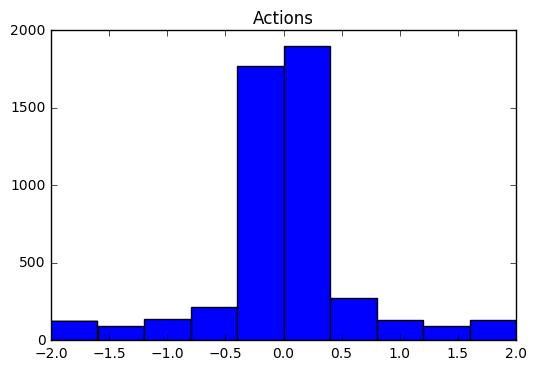

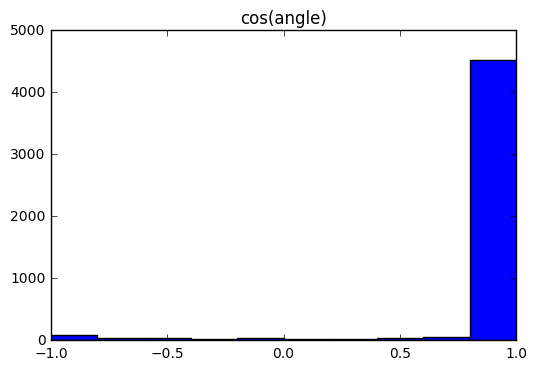

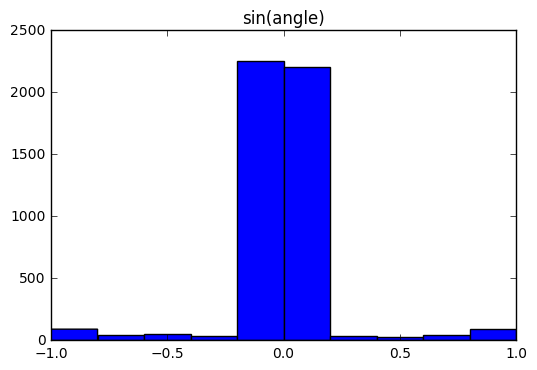

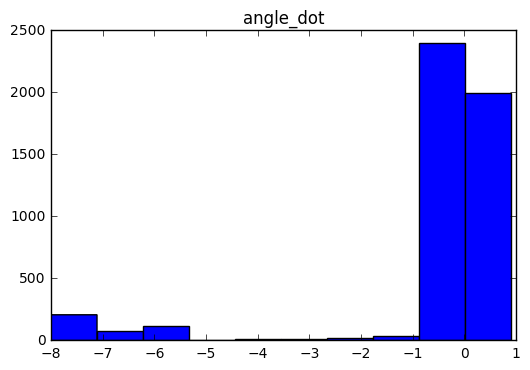

In [11]:
plt.figure()
plt.hist(inputsNumpy[:,0])
plt.title('Actions')
plt.savefig('Actions-Hist-1', format = 'svg')

plt.figure()
plt.hist(inputsNumpy[:,1])
plt.title('cos(angle)')
plt.savefig('Cos-Hist-1', format = 'svg')

plt.figure()
plt.hist(inputsNumpy[:,2])
plt.title('sin(angle)')
plt.savefig('Sin-Hist-1',  format = 'svg')

plt.figure()
plt.hist(inputsNumpy[:,3])
print policyParameters
plt.title('angle_dot')
plt.savefig('Vel-Hist-1', format = 'svg')


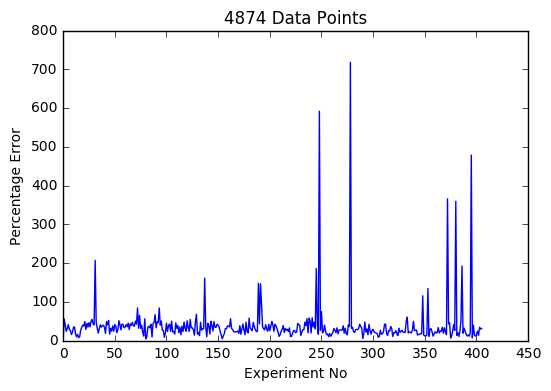

In [19]:
plt.plot(avgErrorSummary)
plt.title('4874 Data Points')
plt.xlabel('Experiment No')
plt.ylabel('Percentage Error')
plt.savefig('4874-datapoints', format = 'svg')

In [ ]:
print inputsNumpy.shape